In [1]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
import pickle
import pandas as pd
import scanpy as sc

In [4]:
sample = 'iGlut_post'

# load expression data

In [5]:
print(sample)

meta = pd.read_csv("scanpy/"+sample+"_dr_clustered_raw_merged_meta.tsv",sep="\t",index_col=0)
meta['M_CycA'] = meta['CycA']
meta.drop('CycA',axis=1,inplace=True)
meta.head()

meta['condition'] = meta['AP_axis'] + "_" + meta['DV_axis']
print(meta['Basal_media'].value_counts())
min_cells_condition = meta['condition'].value_counts().min()
meta = meta.groupby('condition').sample(n=min_cells_condition,random_state=42)


adata = sc.read_h5ad("scanpy/"+sample+"_dr_clustered_raw_merged.h5ad")
adata.obs['BC'] = adata.obs.index
adata = adata[meta.index,:]



iGlut_post
mTeSR    184431
Name: Basal_media, dtype: int64


# create averages per morphogen and condition

In [7]:
def cluster_avg(adata,clustering):
    cluster_avg_subset = pd.DataFrame(columns=adata.var_names, index=adata.obs[clustering].cat.categories)                                                                                                 
    for clust in adata.obs[clustering].cat.categories: 
        cluster_avg_subset.loc[clust] = adata[adata.obs[clustering].isin([clust]),:].X.mean(0)


    cluster_avg_subset = cluster_avg_subset.astype('float')
    cluster_avg_subset = cluster_avg_subset.T
    return(cluster_avg_subset)


In [8]:
#average per morphogen concentration
i = 0

for morph in ['M_RA','M_FGF8','M_XAV','M_CHIR','M_BMP4','M_SHH']:
    meta[morph+"_class"] = meta[morph].astype('str').astype('category')
    adata.obs = meta.loc[adata.obs.index]
    
    tst = cluster_avg(adata,morph+"_class")
    tst.columns = [morph+'_'+x for x in tst.columns]
    
    if i == 0:
        tst_all = tst.copy()
        i+=1
    else:
        tst_all = pd.merge(tst,tst_all,left_index=True,right_index=True)
    
tst_all_CPT = tst_all/tst_all.sum()*1e4
tst_all_CPT = np.log1p(tst_all_CPT)

In [9]:
#average per condition
adata.obs['condition'] = adata.obs['condition'].astype('category')
expr_cond = cluster_avg(adata,"condition")
expr_cond_CPT = expr_cond/expr_cond.sum()*1e4
expr_cond_logCPT = np.log1p(expr_cond_CPT)

# get features from models

In [10]:
#loop over random states
selected_genes_all = []
selected_genes_DV = []


selected_genes_RA = []
selected_genes_CHIR = []
selected_genes_FGF8 = []
selected_genes_XAV = []

for i in [42,21,103,7,48]:
    
    #load regressor model
    print(i)
    import pickle 
    filename = "figures/multiregressor/"+sample+"_mTeSR_"+str(i)+".p"
    filehandler = open(filename, 'rb') 
    regr_multi = pickle.load(filehandler)

    #loop over model in multi model + select top 150 most important features
    for regr_morph in regr_multi.estimators_:
        gene_importances = pd.Series(regr_morph.feature_importances_,index=regr_multi.feature_names_in_)
        selected_genes = gene_importances.loc[gene_importances>0.001].index

        selected_genes = list(gene_importances.sort_values(ascending=False).head(n=150).index)
        selected_genes_all = selected_genes_all + selected_genes

        
        
        
        
    #only loop over DV models and select top 150 most important features
    for regr_morph in regr_multi.estimators_[4:6]:
        gene_importances = pd.Series(regr_morph.feature_importances_,index=regr_multi.feature_names_in_)
        selected_genes = gene_importances.loc[gene_importances>0.001].index
    
        selected_genes = list(gene_importances.sort_values(ascending=False).head(n=150).index)
        selected_genes_DV = selected_genes_DV + selected_genes

        
    #only loop over DV models and select top 150 most important features
    regr_morph = regr_multi.estimators_[0]
    gene_importances = pd.Series(regr_morph.feature_importances_,index=regr_multi.feature_names_in_)
    selected_genes = gene_importances.loc[gene_importances>0.001].index
    selected_genes = list(gene_importances.sort_values(ascending=False).head(n=150).index)
    selected_genes_XAV = selected_genes_XAV + selected_genes
    
    #only loop over DV models and select top 150 most important features
    regr_morph = regr_multi.estimators_[1]
    gene_importances = pd.Series(regr_morph.feature_importances_,index=regr_multi.feature_names_in_)
    selected_genes = gene_importances.loc[gene_importances>0.001].index
    selected_genes = list(gene_importances.sort_values(ascending=False).head(n=150).index)
    selected_genes_CHIR = selected_genes_CHIR + selected_genes

    #only loop over DV models and select top 150 most important features
    regr_morph = regr_multi.estimators_[2]
    gene_importances = pd.Series(regr_morph.feature_importances_,index=regr_multi.feature_names_in_)
    selected_genes = gene_importances.loc[gene_importances>0.001].index
    selected_genes = list(gene_importances.sort_values(ascending=False).head(n=150).index)
    selected_genes_RA = selected_genes_RA + selected_genes

    #only loop over DV models and select top 150 most important features
    regr_morph = regr_multi.estimators_[3]
    gene_importances = pd.Series(regr_morph.feature_importances_,index=regr_multi.feature_names_in_)
    selected_genes = gene_importances.loc[gene_importances>0.001].index
    selected_genes = list(gene_importances.sort_values(ascending=False).head(n=150).index)
    selected_genes_FGF8 = selected_genes_FGF8 + selected_genes


42
21
103
7
48


In [11]:
f=open('RF_modules/'+sample+'/all_selected_genes.txt','w')
for ele in selected_genes_all:
    f.write(ele+'\n')
f.close() 


# DV genes for BMP4 and SHH

In [12]:
print(len(selected_genes_DV))
selected_genes_DV = list(set(selected_genes_DV))
print(len(selected_genes_DV))

1500
259


In [13]:
ctrl_BMP4 = [x for x in expr_cond_logCPT if 'ctrl_BMP4' in x]
ctrl_SHH = [x for x in expr_cond_logCPT if 'ctrl_SHH' in x]
ctrl_ctrl = [x for x in expr_cond_logCPT if 'ctrl_ctrl' in x]
ordered_cols = ctrl_ctrl + ctrl_SHH + ctrl_BMP4

expr_cond_DV = expr_cond_logCPT[ordered_cols].copy()
ordered_cols_minmax = (expr_cond_DV.T-expr_cond_DV.T.min())/(expr_cond_DV.T.max()-expr_cond_DV.T.min())
ordered_cols_minmax = ordered_cols_minmax.T

In [14]:
ordered_cols_minmax_sel = ordered_cols_minmax.loc[selected_genes_DV].copy()
ordered_cols_minmax_sel = ordered_cols_minmax_sel.dropna()

In [15]:
# get modules based on clustering 
import scipy.cluster.hierarchy as sch

distance_df = ordered_cols_minmax_sel.copy()
# retrieve clusters using fcluster 
metric='euclidean'
method='complete'
d = sch.distance.pdist(distance_df,metric=metric)
L = sch.linkage(d, method=method,metric=metric)
# 0.2 can be modified to retrieve more stringent or relaxed clusters
clusters = sch.fcluster(L, 0.5*d.max(), 'distance')
print(len(set(clusters)))
# clusters indicices correspond to incides of original df
region_modules = pd.Series(clusters,index=distance_df.index)

8


In [16]:
module_sizes = region_modules.value_counts()
module_sizes = module_sizes[module_sizes>10]
selected_modules = list(module_sizes.index)
module_sizes

8    126
3     69
7     30
1     19
dtype: int64

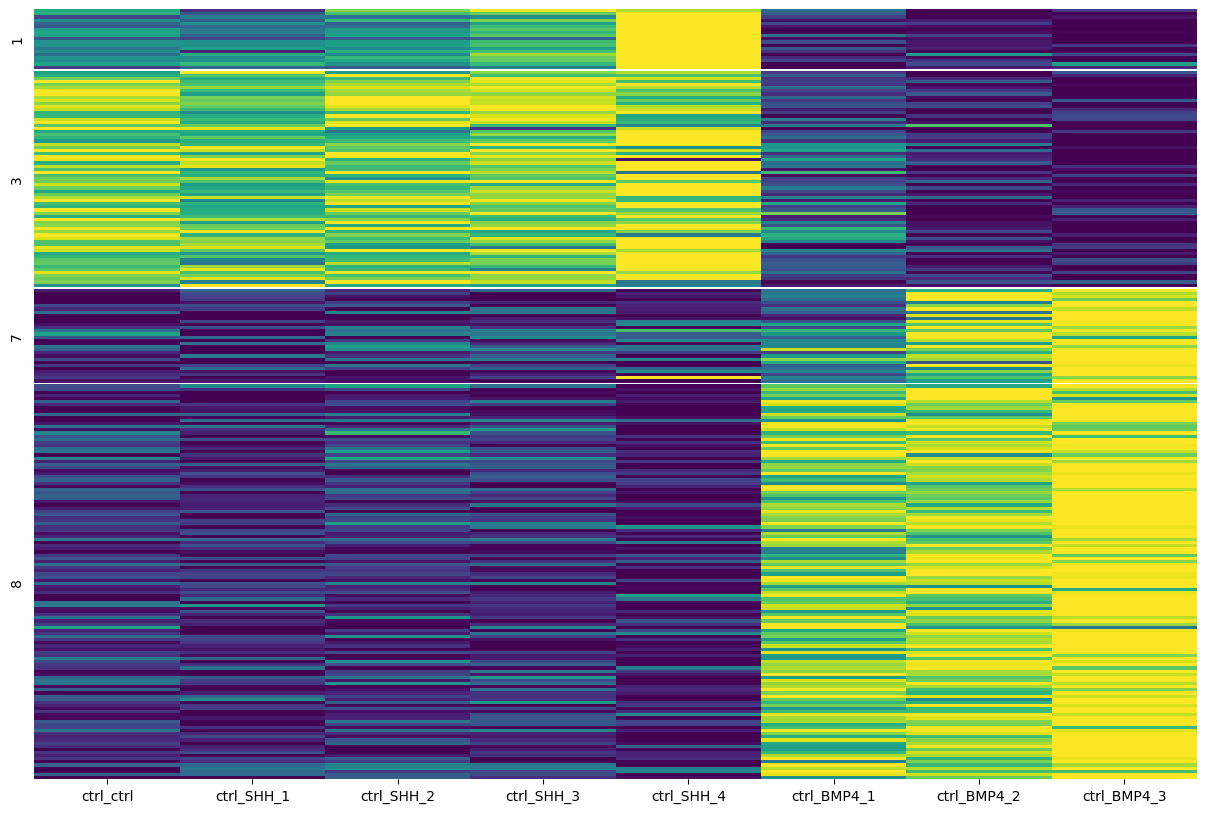

In [17]:
import matplotlib.gridspec as gridspec
number_module = len(set(selected_modules))

hratios = []
for module in set(region_modules):
    if module in selected_modules:
        plotting_regions = region_modules.loc[region_modules==module].index
        hratios.append(len(plotting_regions))
        
        
fig = plt.figure(figsize=(15, 10))
outer = gridspec.GridSpec(number_module, 1, wspace=0.05, hspace=0.01,height_ratios=hratios)
i=0
l=0
for module in set(region_modules):
    if module in selected_modules:
        plotting_regions = region_modules.loc[region_modules==module].index
        
        
        f=open('RF_modules/'+sample+'/DV/DV_'+str(module)+'.txt','w')
        for ele in plotting_regions:
            f.write(ele+'\n')
        f.close() 

        ax1 = plt.Subplot(fig, outer[l])
        sns.heatmap(ordered_cols_minmax_sel.loc[plotting_regions],cmap='viridis',vmin=0,vmax=1,ax=ax1,cbar=False)
        sns.despine(top=True,bottom=True,left=True,ax=ax1)
        ax1.set_yticks([])
        ax1.set_ylabel(str(module))
        if l < len(selected_modules)-1:
            ax1.set_xticks([])
        fig.add_subplot(ax1)
        l+=1       

plt.savefig('RF_modules/'+sample+'_DV.png',dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

# AP genes for RA

In [18]:
RA_cols = [x for x in expr_cond_logCPT if 'RA' in x]
RA_cols = [x for x in RA_cols if 'ctrl' in x]
RA_cols_CHIR = [x for x in RA_cols if 'CHIR' in x]
RA_cols = [x for x in RA_cols if not 'CHIR' in x]

ctrl_ctrl = [x for x in expr_cond_logCPT if 'ctrl_ctrl' in x]
ordered_cols = ctrl_ctrl + RA_cols + RA_cols_CHIR

expr_cond_DV = expr_cond_logCPT[ordered_cols].copy()
ordered_cols_minmax = (expr_cond_DV.T-expr_cond_DV.T.min())/(expr_cond_DV.T.max()-expr_cond_DV.T.min())
ordered_cols_minmax = ordered_cols_minmax.T

In [19]:
print(len(selected_genes_RA))
selected_genes_RA = list(set(selected_genes_RA))
print(len(selected_genes_RA))

750
222


In [20]:
ordered_cols_minmax_sel = ordered_cols_minmax.loc[selected_genes_RA].copy()
ordered_cols_minmax_sel = ordered_cols_minmax_sel.dropna()

# get modules based on clustering 
import scipy.cluster.hierarchy as sch

distance_df = ordered_cols_minmax_sel.copy()
# retrieve clusters using fcluster 
metric='euclidean'
method='complete'
d = sch.distance.pdist(distance_df,metric=metric)
L = sch.linkage(d, method=method,metric=metric)
# 0.2 can be modified to retrieve more stringent or relaxed clusters
clusters = sch.fcluster(L, 0.5*d.max(), 'distance')
print(len(set(clusters)))
# clusters indicices correspond to incides of original df
region_modules = pd.Series(clusters,index=distance_df.index)

#filter modules
module_sizes = region_modules.value_counts()
module_sizes = module_sizes[module_sizes>10]
selected_modules = list(module_sizes.index)
module_sizes


12


10    54
3     36
12    30
9     24
6     15
5     13
8     13
2     12
dtype: int64

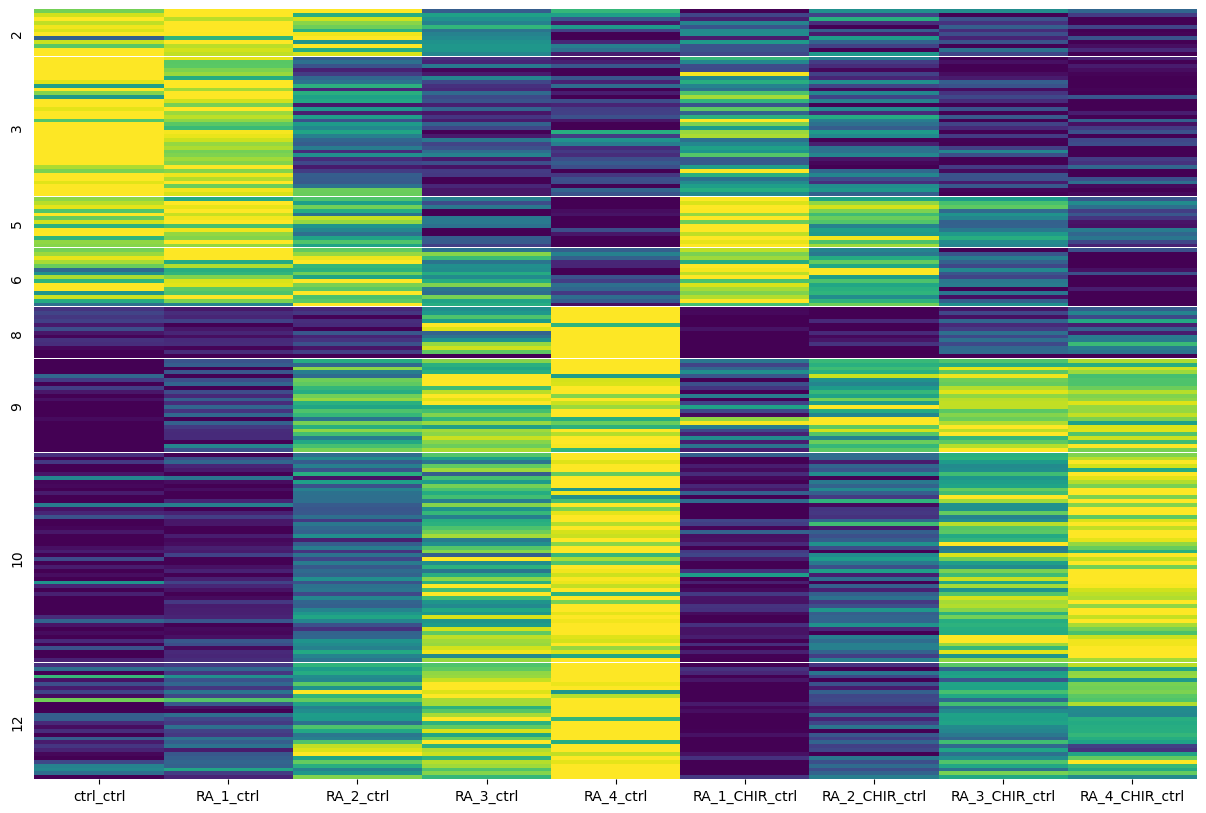

In [21]:
import matplotlib.gridspec as gridspec
number_module = len(set(selected_modules))

hratios = []
for module in set(region_modules):
    if module in selected_modules:
        plotting_regions = region_modules.loc[region_modules==module].index
        hratios.append(len(plotting_regions))
        
        
fig = plt.figure(figsize=(15, 10))
outer = gridspec.GridSpec(number_module, 1, wspace=0.05, hspace=0.01,height_ratios=hratios)
i=0
l=0
for module in set(region_modules):
    if module in selected_modules:
        plotting_regions = region_modules.loc[region_modules==module].index
        
        
        f=open('RF_modules/'+sample+'/RA/RA_'+str(module)+'.txt','w')
        for ele in plotting_regions:
            f.write(ele+'\n')
        f.close() 

        ax1 = plt.Subplot(fig, outer[l])
        sns.heatmap(ordered_cols_minmax_sel.loc[plotting_regions],cmap='viridis',vmin=0,vmax=1,ax=ax1,cbar=False)
        sns.despine(top=True,bottom=True,left=True,ax=ax1)
        ax1.set_yticks([])
        ax1.set_ylabel(str(module))
        if l < len(selected_modules)-1:
            ax1.set_xticks([])
        fig.add_subplot(ax1)
        l+=1       

plt.savefig('RF_modules/'+sample+'_RA.png',dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

In [22]:
RA_cols = [x for x in expr_cond_logCPT if 'FGF8' in x]
RA_cols = [x for x in RA_cols if 'ctrl' in x]
RA_cols_CHIR = [x for x in RA_cols if 'CHIR' in x]
RA_cols = [x for x in RA_cols if not 'CHIR' in x]

ctrl_ctrl = [x for x in expr_cond_logCPT if 'ctrl_ctrl' in x]
ordered_cols = ctrl_ctrl + RA_cols + RA_cols_CHIR
print(ordered_cols)


expr_cond_DV = expr_cond_logCPT[ordered_cols].copy()
ordered_cols_minmax = (expr_cond_DV.T-expr_cond_DV.T.min())/(expr_cond_DV.T.max()-expr_cond_DV.T.min())
ordered_cols_minmax = ordered_cols_minmax.T

['ctrl_ctrl', 'FGF8_1_ctrl', 'FGF8_2_ctrl', 'FGF8_3_ctrl', 'FGF8_4_ctrl', 'FGF8_1_CHIR_ctrl', 'FGF8_2_CHIR_ctrl', 'FGF8_3_CHIR_ctrl', 'FGF8_4_CHIR_ctrl']


In [23]:
print(len(selected_genes_FGF8))
selected_genes_FGF8 = list(set(selected_genes_FGF8))
print(len(selected_genes_FGF8))

750
259


In [24]:
ordered_cols_minmax_sel = ordered_cols_minmax.loc[selected_genes_FGF8].copy()
ordered_cols_minmax_sel = ordered_cols_minmax_sel.dropna()

# get modules based on clustering 
import scipy.cluster.hierarchy as sch

distance_df = ordered_cols_minmax_sel.copy()
# retrieve clusters using fcluster 
metric='euclidean'
method='complete'
d = sch.distance.pdist(distance_df,metric=metric)
L = sch.linkage(d, method=method,metric=metric)
# 0.2 can be modified to retrieve more stringent or relaxed clusters
clusters = sch.fcluster(L, 0.5*d.max(), 'distance')
print(len(set(clusters)))
# clusters indicices correspond to incides of original df
region_modules = pd.Series(clusters,index=distance_df.index)

#filter modules
module_sizes = region_modules.value_counts()
module_sizes = module_sizes[module_sizes>10]
selected_modules = list(module_sizes.index)
module_sizes


21


14    74
5     52
4     34
12    18
10    14
dtype: int64

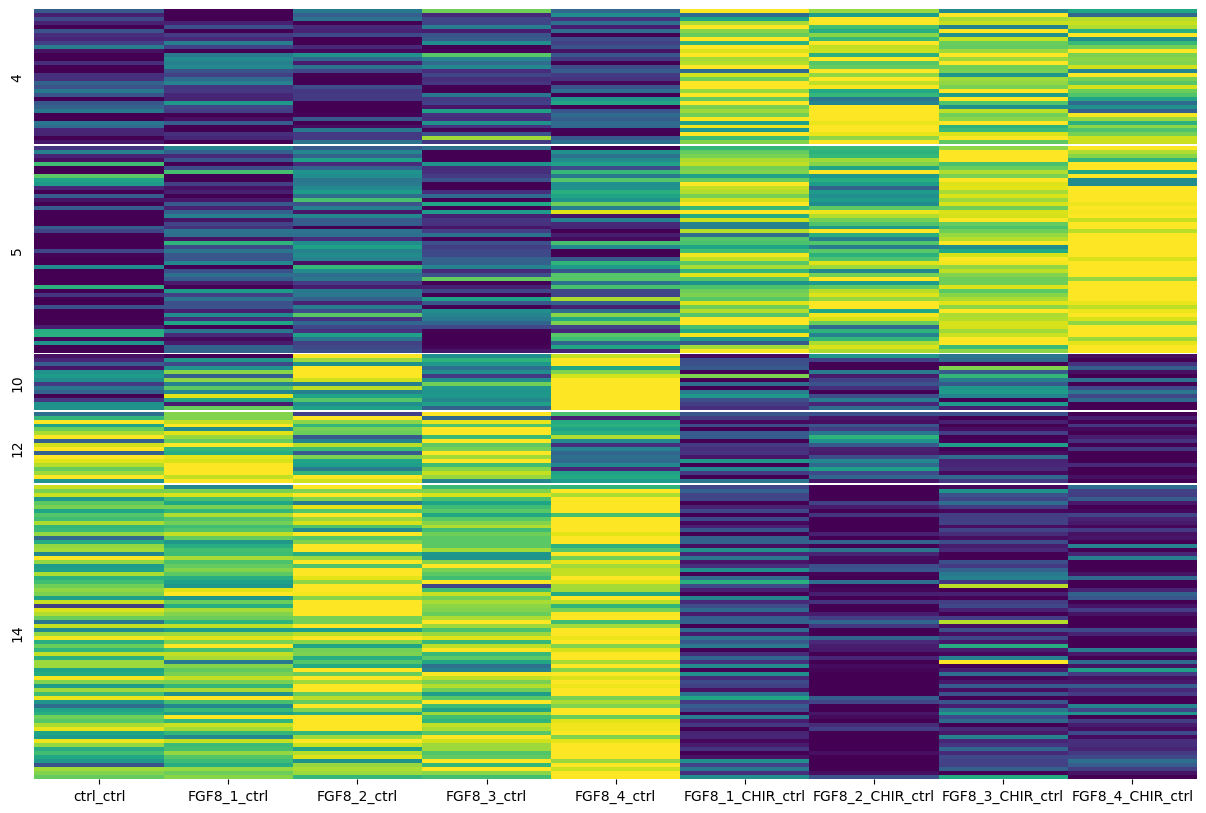

In [25]:
import matplotlib.gridspec as gridspec
number_module = len(set(selected_modules))

hratios = []
for module in set(region_modules):
    if module in selected_modules:
        plotting_regions = region_modules.loc[region_modules==module].index
        hratios.append(len(plotting_regions))
        
        
fig = plt.figure(figsize=(15, 10))
outer = gridspec.GridSpec(number_module, 1, wspace=0.05, hspace=0.01,height_ratios=hratios)
i=0
l=0
for module in set(region_modules):
    if module in selected_modules:
        plotting_regions = region_modules.loc[region_modules==module].index
        
        
        f=open('RF_modules/'+sample+'/FGF8/FGF_'+str(module)+'.txt','w')
        for ele in plotting_regions:
            f.write(ele+'\n')
        f.close() 

        ax1 = plt.Subplot(fig, outer[l])
        sns.heatmap(ordered_cols_minmax_sel.loc[plotting_regions],cmap='viridis',vmin=0,vmax=1,ax=ax1,cbar=False)
        sns.despine(top=True,bottom=True,left=True,ax=ax1)
        ax1.set_yticks([])
        ax1.set_ylabel(str(module))
        if l < len(selected_modules)-1:
            ax1.set_xticks([])
        fig.add_subplot(ax1)
        l+=1       

plt.savefig('RF_modules/'+sample+'_FGF8.png',dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

In [26]:
RA_cols = [x for x in expr_cond_logCPT if 'XAV' in x]
RA_cols = [x for x in RA_cols if 'ctrl' in x]
RA_cols_CHIR = [x for x in RA_cols if 'CHIR' in x]
RA_cols = [x for x in RA_cols if not 'CHIR' in x]

ctrl_ctrl = [x for x in expr_cond_logCPT if 'ctrl_ctrl' in x]
ordered_cols = ctrl_ctrl + RA_cols + RA_cols_CHIR
print(ordered_cols)


expr_cond_DV = expr_cond_logCPT[ordered_cols].copy()
ordered_cols_minmax = (expr_cond_DV.T-expr_cond_DV.T.min())/(expr_cond_DV.T.max()-expr_cond_DV.T.min())
ordered_cols_minmax = ordered_cols_minmax.T

['ctrl_ctrl', 'XAV_1_ctrl', 'XAV_2_ctrl', 'XAV_3_ctrl']


In [27]:
print(len(selected_genes_XAV))
selected_genes_XAV = list(set(selected_genes_XAV))
print(len(selected_genes_XAV))

750
302


In [28]:
ordered_cols_minmax_sel = ordered_cols_minmax.loc[selected_genes_XAV].copy()
ordered_cols_minmax_sel = ordered_cols_minmax_sel.dropna()

# get modules based on clustering 
import scipy.cluster.hierarchy as sch

distance_df = ordered_cols_minmax_sel.copy()
# retrieve clusters using fcluster 
metric='euclidean'
method='complete'
d = sch.distance.pdist(distance_df,metric=metric)
L = sch.linkage(d, method=method,metric=metric)
# 0.2 can be modified to retrieve more stringent or relaxed clusters
clusters = sch.fcluster(L, 0.5*d.max(), 'distance')
print(len(set(clusters)))
# clusters indicices correspond to incides of original df
region_modules = pd.Series(clusters,index=distance_df.index)

#filter modules
module_sizes = region_modules.value_counts()
module_sizes = module_sizes[module_sizes>10]
selected_modules = list(module_sizes.index)
module_sizes


14


11    69
1     39
12    29
8     28
3     26
2     20
7     17
10    16
4     15
dtype: int64

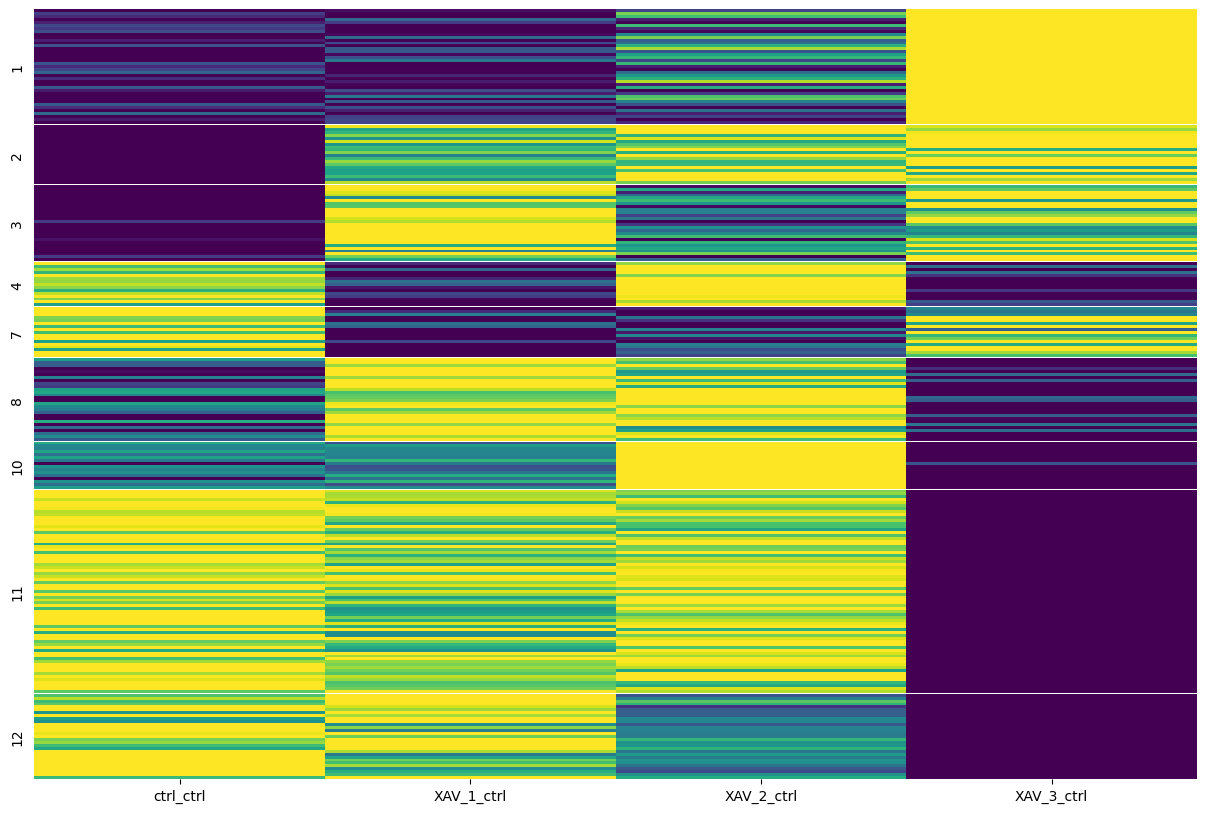

In [29]:
import matplotlib.gridspec as gridspec
number_module = len(set(selected_modules))

hratios = []
for module in set(region_modules):
    if module in selected_modules:
        plotting_regions = region_modules.loc[region_modules==module].index
        hratios.append(len(plotting_regions))
        
        
fig = plt.figure(figsize=(15, 10))
outer = gridspec.GridSpec(number_module, 1, wspace=0.05, hspace=0.01,height_ratios=hratios)
i=0
l=0
for module in set(region_modules):
    if module in selected_modules:
        plotting_regions = region_modules.loc[region_modules==module].index
        
        
        f=open('RF_modules/'+sample+'/XAV/XAV_'+str(module)+'.txt','w')
        for ele in plotting_regions:
            f.write(ele+'\n')
        f.close() 

        ax1 = plt.Subplot(fig, outer[l])
        sns.heatmap(ordered_cols_minmax_sel.loc[plotting_regions],cmap='viridis',vmin=0,vmax=1,ax=ax1,cbar=False)
        sns.despine(top=True,bottom=True,left=True,ax=ax1)
        ax1.set_yticks([])
        ax1.set_ylabel(str(module))
        if l < len(selected_modules)-1:
            ax1.set_xticks([])
        fig.add_subplot(ax1)
        l+=1       

plt.savefig('RF_modules/'+sample+'_XAV.png',dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

In [30]:
RA_cols = [x for x in expr_cond_logCPT if 'CHIR' in x]
RA_cols = [x for x in RA_cols if 'ctrl' in x]
RA_cols_CHIR = [x for x in RA_cols if 'CHIR' in x]
RA_cols = [x for x in RA_cols if not 'CHIR' in x]

ctrl_ctrl = [x for x in expr_cond_logCPT if 'ctrl_ctrl' in x]
ordered_cols = ctrl_ctrl + RA_cols + RA_cols_CHIR
print(ordered_cols)


expr_cond_DV = expr_cond_logCPT[ordered_cols].copy()
ordered_cols_minmax = (expr_cond_DV.T-expr_cond_DV.T.min())/(expr_cond_DV.T.max()-expr_cond_DV.T.min())
ordered_cols_minmax = ordered_cols_minmax.T

['ctrl_ctrl', 'CHIR_1_ctrl', 'CHIR_2_ctrl', 'CHIR_3_ctrl', 'CHIR_4_ctrl', 'FGF8_1_CHIR_ctrl', 'FGF8_2_CHIR_ctrl', 'FGF8_3_CHIR_ctrl', 'FGF8_4_CHIR_ctrl', 'RA_1_CHIR_ctrl', 'RA_2_CHIR_ctrl', 'RA_3_CHIR_ctrl', 'RA_4_CHIR_ctrl']


In [31]:
print(len(selected_genes_CHIR))
selected_genes_CHIR = list(set(selected_genes_CHIR))
print(len(selected_genes_CHIR))

750
240


In [32]:
ordered_cols_minmax_sel = ordered_cols_minmax.loc[selected_genes_CHIR].copy()
ordered_cols_minmax_sel = ordered_cols_minmax_sel.dropna()

# get modules based on clustering 
import scipy.cluster.hierarchy as sch

distance_df = ordered_cols_minmax_sel.copy()
# retrieve clusters using fcluster 
metric='euclidean'
method='complete'
d = sch.distance.pdist(distance_df,metric=metric)
L = sch.linkage(d, method=method,metric=metric)
# 0.2 can be modified to retrieve more stringent or relaxed clusters
clusters = sch.fcluster(L, 0.5*d.max(), 'distance')
print(len(set(clusters)))
# clusters indicices correspond to incides of original df
region_modules = pd.Series(clusters,index=distance_df.index)

#filter modules
module_sizes = region_modules.value_counts()
module_sizes = module_sizes[module_sizes>10]
selected_modules = list(module_sizes.index)
module_sizes


15


11    59
8     26
4     25
6     24
14    21
9     18
10    16
7     11
dtype: int64

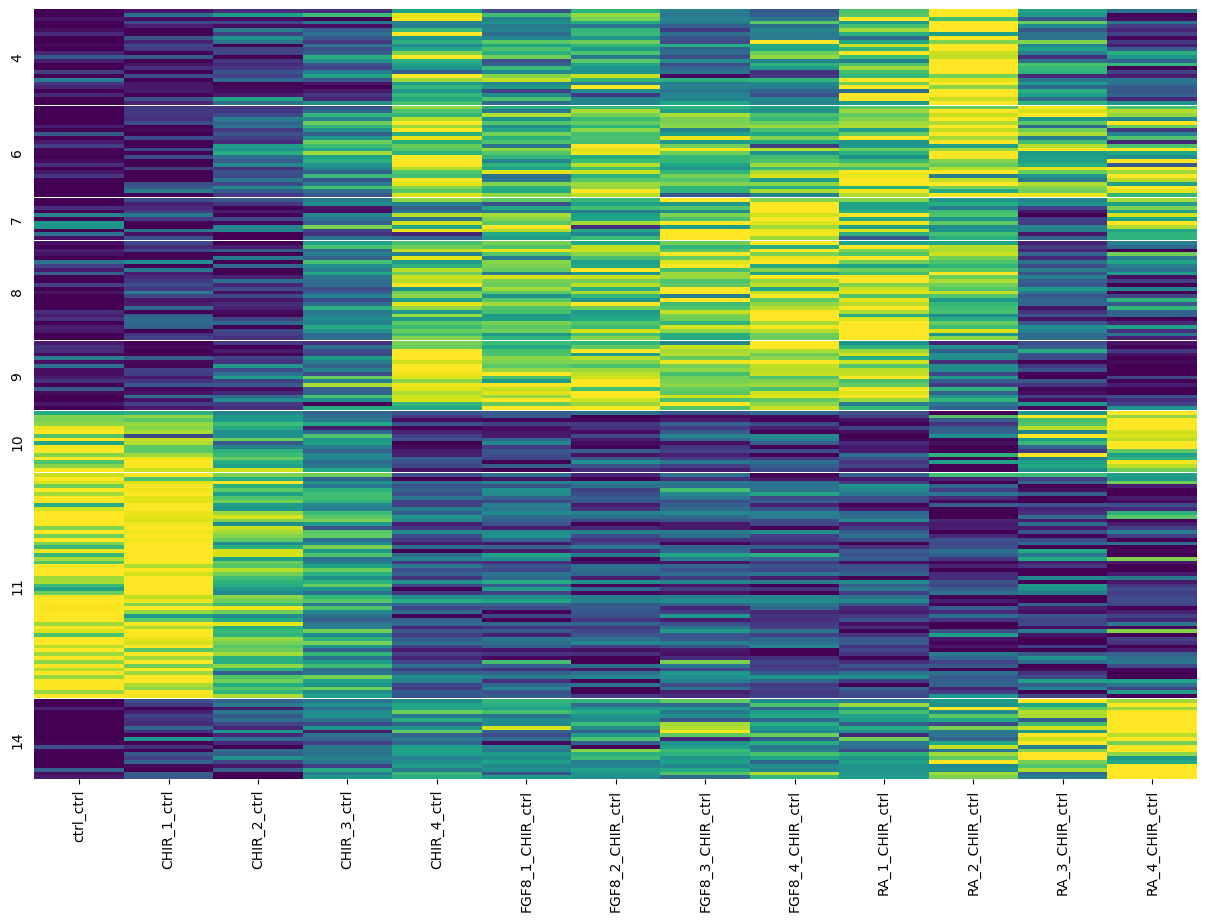

In [33]:
import matplotlib.gridspec as gridspec
number_module = len(set(selected_modules))

hratios = []
for module in set(region_modules):
    if module in selected_modules:
        plotting_regions = region_modules.loc[region_modules==module].index
        hratios.append(len(plotting_regions))
        
        
fig = plt.figure(figsize=(15, 10))
outer = gridspec.GridSpec(number_module, 1, wspace=0.05, hspace=0.01,height_ratios=hratios)
i=0
l=0
for module in set(region_modules):
    if module in selected_modules:
        plotting_regions = region_modules.loc[region_modules==module].index
        
        
        f=open('RF_modules/'+sample+'/CHIR/CHIR_'+str(module)+'.txt','w')
        for ele in plotting_regions:
            f.write(ele+'\n')
        f.close() 

        ax1 = plt.Subplot(fig, outer[l])
        sns.heatmap(ordered_cols_minmax_sel.loc[plotting_regions],cmap='viridis',vmin=0,vmax=1,ax=ax1,cbar=False)
        sns.despine(top=True,bottom=True,left=True,ax=ax1)
        ax1.set_yticks([])
        ax1.set_ylabel(str(module))
        if l < len(selected_modules)-1:
            ax1.set_xticks([])
        fig.add_subplot(ax1)
        l+=1       

plt.savefig('RF_modules/'+sample+'_CHIR.png',dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

In [34]:
RA_cols = [x for x in expr_cond_logCPT.columns if 'RA' in x]
RA_cols = [x for x in RA_cols if 'ctrl' in x]
RA_cols = [x for x in RA_cols if not 'CHIR' in x]

RA_BMP4_cols = [x for x in expr_cond_logCPT.columns if 'RA' in x]
RA_BMP4_cols = [x for x in RA_BMP4_cols if 'BMP4' in x]
RA_BMP4_cols = [x for x in RA_BMP4_cols if not 'CHIR' in x]

BMP4_cols = [x for x in expr_cond_logCPT.columns if 'BMP4' in x]
BMP4_cols = [x for x in BMP4_cols if 'ctrl' in x]
BMP4_cols = [x for x in BMP4_cols if not 'CHIR' in x]

ctrl_ctrl = [x for x in expr_cond_logCPT if 'ctrl_ctrl' in x]


ordered_cols1 =  RA_cols + RA_BMP4_cols + BMP4_cols

ordered_cols1 = ctrl_ctrl + BMP4_cols
ordered_cols = RA_cols + RA_BMP4_cols

import re
ordered_cols1 = [re.sub('_ctrl$','_AA',x) for x in ordered_cols1]
ordered_cols1 = sorted(ordered_cols1)
ordered_cols1 = [re.sub('_AA','_ctrl',x) for x in ordered_cols1]


ordered_cols = [re.sub('_ctrl$','_AA',x) for x in ordered_cols]
ordered_cols = sorted(ordered_cols)
ordered_cols = [re.sub('_AA','_ctrl',x) for x in ordered_cols]

ordered_cols = ordered_cols1 + ordered_cols

In [35]:
expr_cond_DV = expr_cond_logCPT[ordered_cols].copy()
ordered_cols_minmax = (expr_cond_DV.T-expr_cond_DV.T.min())/(expr_cond_DV.T.max()-expr_cond_DV.T.min())
ordered_cols_minmax = ordered_cols_minmax.T

In [36]:
selected_genes_RA = list(set(selected_genes_RA))
selected_genes_BMP4 = selected_genes_DV
selected_genes_BMP4 = list(set(selected_genes_BMP4))

selected_genes_RA_BMP4 = selected_genes_BMP4 + selected_genes_RA
selected_genes_RA_BMP4 = list(set(selected_genes_RA_BMP4))
print(len(selected_genes_RA_BMP4))

424


In [37]:
ordered_cols_minmax_sel = ordered_cols_minmax.loc[selected_genes_RA_BMP4].copy()
ordered_cols_minmax_sel = ordered_cols_minmax_sel.dropna()

# get modules based on clustering 
import scipy.cluster.hierarchy as sch

distance_df = ordered_cols_minmax_sel.copy()
# retrieve clusters using fcluster 
metric='euclidean'
method='complete'
d = sch.distance.pdist(distance_df,metric=metric)
L = sch.linkage(d, method=method,metric=metric)
# 0.2 can be modified to retrieve more stringent or relaxed clusters
clusters = sch.fcluster(L, 0.5*d.max(), 'distance')
print(len(set(clusters)))
# clusters indicices correspond to incides of original df
region_modules = pd.Series(clusters,index=distance_df.index)

#filter modules
module_sizes = region_modules.value_counts()
module_sizes = module_sizes[module_sizes>10]
selected_modules = list(module_sizes.index)
module_sizes


19


3     55
16    44
10    37
19    34
2     34
4     31
12    24
6     20
11    20
18    17
1     15
5     15
7     14
9     14
8     12
17    12
15    11
14    11
dtype: int64

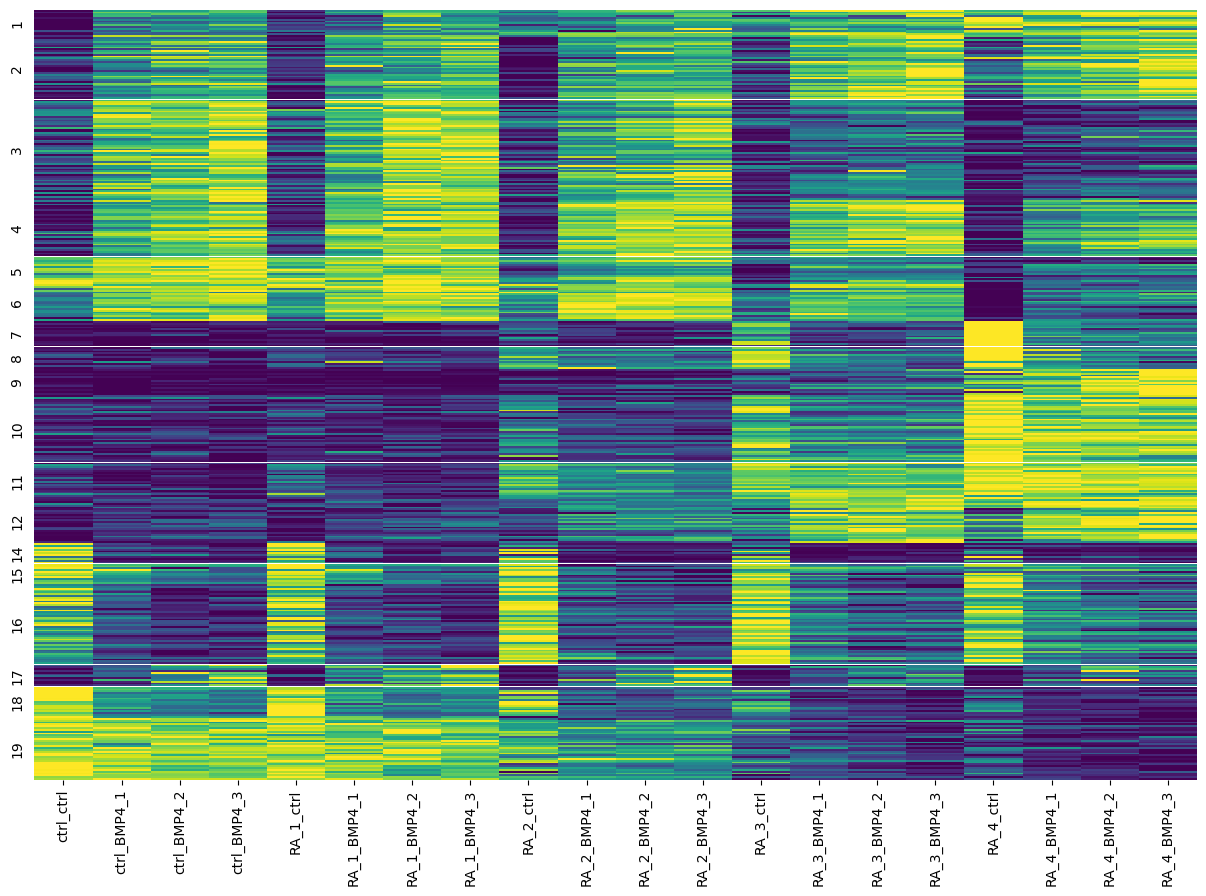

In [38]:
import matplotlib.gridspec as gridspec
number_module = len(set(selected_modules))

hratios = []
for module in set(region_modules):
    if module in selected_modules:
        plotting_regions = region_modules.loc[region_modules==module].index
        hratios.append(len(plotting_regions))
        
        
fig = plt.figure(figsize=(15, 10))
outer = gridspec.GridSpec(number_module, 1, wspace=0.05, hspace=0.01,height_ratios=hratios)
i=0
l=0
for module in set(region_modules):
    if module in selected_modules:
        plotting_regions = region_modules.loc[region_modules==module].index
        
        
        f=open('RF_modules/'+sample+'/RA_BMP4_'+str(module)+'.txt','w')
        for ele in plotting_regions:
            f.write(ele+'\n')
        f.close() 

        ax1 = plt.Subplot(fig, outer[l])
        sns.heatmap(ordered_cols_minmax_sel.loc[plotting_regions],cmap='viridis',vmin=0,vmax=1,ax=ax1,cbar=False)
        sns.despine(top=True,bottom=True,left=True,ax=ax1)
        ax1.set_yticks([])
        ax1.set_ylabel(str(module))
        if l < len(selected_modules)-1:
            ax1.set_xticks([])
        fig.add_subplot(ax1)
        l+=1       

plt.savefig('RF_modules/'+sample+'_RA_BMP4.png',dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

In [39]:
RA_cols = [x for x in expr_cond_logCPT.columns if 'RA' in x]
RA_cols = [x for x in RA_cols if 'ctrl' in x]
RA_cols = [x for x in RA_cols if not 'CHIR' in x]

RA_BMP4_cols = [x for x in expr_cond_logCPT.columns if 'RA' in x]
RA_BMP4_cols = [x for x in RA_BMP4_cols if 'SHH' in x]
RA_BMP4_cols = [x for x in RA_BMP4_cols if not 'CHIR' in x]

BMP4_cols = [x for x in expr_cond_logCPT.columns if 'SHH' in x]
BMP4_cols = [x for x in BMP4_cols if 'ctrl' in x]
BMP4_cols = [x for x in BMP4_cols if not 'CHIR' in x]

ctrl_ctrl = [x for x in expr_cond_logCPT if 'ctrl_ctrl' in x]


ordered_cols1 =  RA_cols + RA_BMP4_cols + BMP4_cols

ordered_cols1 = ctrl_ctrl + BMP4_cols
ordered_cols = RA_cols + RA_BMP4_cols

import re
ordered_cols1 = [re.sub('_ctrl$','_AA',x) for x in ordered_cols1]
ordered_cols1 = sorted(ordered_cols1)
ordered_cols1 = [re.sub('_AA','_ctrl',x) for x in ordered_cols1]


ordered_cols = [re.sub('_ctrl$','_AA',x) for x in ordered_cols]
ordered_cols = sorted(ordered_cols)
ordered_cols = [re.sub('_AA','_ctrl',x) for x in ordered_cols]

ordered_cols = ordered_cols1 + ordered_cols

In [40]:
expr_cond_DV = expr_cond_logCPT[ordered_cols].copy()
ordered_cols_minmax = (expr_cond_DV.T-expr_cond_DV.T.min())/(expr_cond_DV.T.max()-expr_cond_DV.T.min())
ordered_cols_minmax = ordered_cols_minmax.T

In [41]:
selected_genes_RA = list(set(selected_genes_RA))
selected_genes_BMP4 = selected_genes_DV
selected_genes_BMP4 = list(set(selected_genes_BMP4))

selected_genes_RA_BMP4 = selected_genes_BMP4 + selected_genes_RA
selected_genes_RA_BMP4 = list(set(selected_genes_RA_BMP4))
print(len(selected_genes_RA_BMP4))

424


In [42]:
ordered_cols_minmax_sel = ordered_cols_minmax.loc[selected_genes_RA_BMP4].copy()
ordered_cols_minmax_sel = ordered_cols_minmax_sel.dropna()

# get modules based on clustering 
import scipy.cluster.hierarchy as sch

distance_df = ordered_cols_minmax_sel.copy()
# retrieve clusters using fcluster 
metric='euclidean'
method='complete'
d = sch.distance.pdist(distance_df,metric=metric)
L = sch.linkage(d, method=method,metric=metric)
# 0.2 can be modified to retrieve more stringent or relaxed clusters
clusters = sch.fcluster(L, 0.5*d.max(), 'distance')
print(len(set(clusters)))
# clusters indicices correspond to incides of original df
region_modules = pd.Series(clusters,index=distance_df.index)

#filter modules
module_sizes = region_modules.value_counts()
module_sizes = module_sizes[module_sizes>10]
selected_modules = list(module_sizes.index)
module_sizes


32


1     79
27    76
2     34
23    32
22    29
5     19
9     14
13    13
26    12
3     12
28    11
dtype: int64

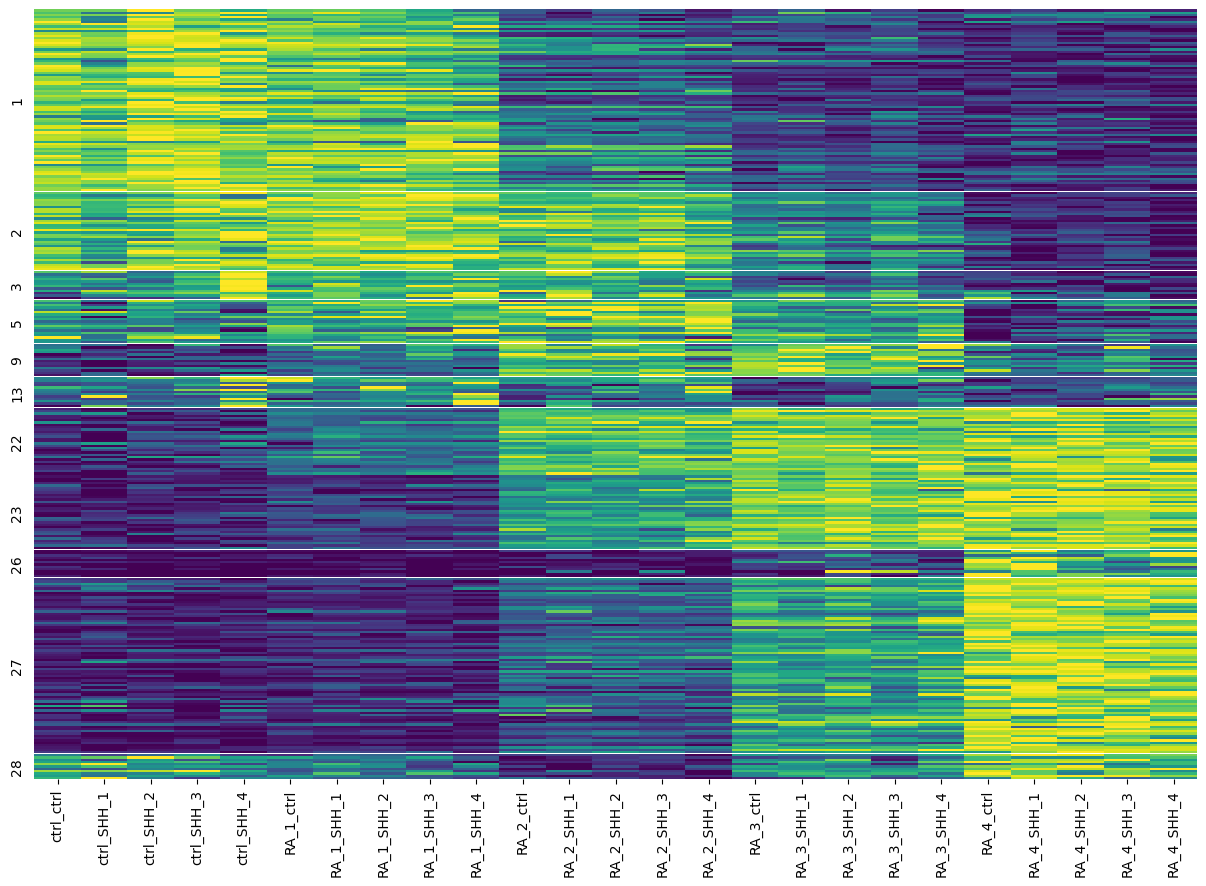

In [43]:
import matplotlib.gridspec as gridspec
number_module = len(set(selected_modules))

hratios = []
for module in set(region_modules):
    if module in selected_modules:
        plotting_regions = region_modules.loc[region_modules==module].index
        hratios.append(len(plotting_regions))
        
        
fig = plt.figure(figsize=(15, 10))
outer = gridspec.GridSpec(number_module, 1, wspace=0.05, hspace=0.01,height_ratios=hratios)
i=0
l=0
for module in set(region_modules):
    if module in selected_modules:
        plotting_regions = region_modules.loc[region_modules==module].index
        
        
        f=open('RF_modules/'+sample+'/RA_SHH_'+str(module)+'.txt','w')
        for ele in plotting_regions:
            f.write(ele+'\n')
        f.close() 

        ax1 = plt.Subplot(fig, outer[l])
        sns.heatmap(ordered_cols_minmax_sel.loc[plotting_regions],cmap='viridis',vmin=0,vmax=1,ax=ax1,cbar=False)
        sns.despine(top=True,bottom=True,left=True,ax=ax1)
        ax1.set_yticks([])
        ax1.set_ylabel(str(module))
        if l < len(selected_modules)-1:
            ax1.set_xticks([])
        fig.add_subplot(ax1)
        l+=1       

plt.savefig('RF_modules/'+sample+'_RA_SHH.png',dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()